In [1]:
import pandas as pd
import numpy as np
import modules
import random

from scipy.stats import beta
from modules import ml_functions
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# 1.0 Data retrieval

In [2]:
df = pd.read_excel('../../data_lake/input/CTG.xls',sheet_name='Raw Data',skiprows=[1])

In [3]:
df = df[:-3]

# 2.0 Data preparation

In [4]:
df = df.drop(columns=['FileName','Date','A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP','b','e','CLASS'])

In [5]:
df = df.set_index('SegFile')

In [6]:
for i in df:
    if df[i].nunique() == 1:
        df = df.drop(columns=i)

In [7]:
df['Tendency'] = df['Tendency'].astype(str)
df['NSP'] = df['NSP'].astype(str)

# 3.0 Modeling

In [8]:
df_ml = df.copy()

## 3.1 Classe 1 - Normale

In [9]:
class_nsp = 1.0

(942, 22)
AUC Score:  0.5594313175810973
Adversarial validation check: NO CONCEPT DRIFT: Train and Test set are statistical similar
GridSearchCV results...
Mean Train Scores: 
[0.97244563 0.97543512 0.98472808 0.9863881 ]

Mean CV Scores: 
[0.93231788 0.93363355 0.93763355 0.93099338]

Best Parameters: 
{'model__depth': 4, 'model__iterations': 500}

Test results...
Model Test Accuracy: 0.9312169312169312
--------------------------------------------------
Model Test Confusion Matrix
First ten features by importances:
['AC', 'ASTV', 'MSTV', 'ALTV', 'Mean', 'DP', 'Mode', 'UC', 'Variance', 'Median']


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

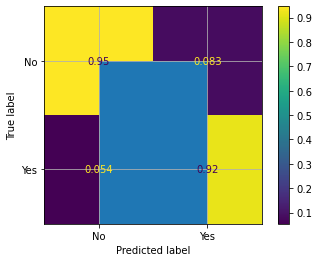

In [10]:
df_model, df_ml = ml_functions.model_preparation(df_ml,class_nsp)
X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, parameters = ml_functions.data_splitting(df_model)
model = ml_functions.model_training(X_train, y_train, numerical_cols, categorical_cols, parameters)
model = ml_functions.model_evaluation(model,X_test,y_test)
df = ml_functions.model_serving(df,model,class_nsp,X_test)
df['proba_classe_1.0'].hist()

## 3.2 Classe 2 - Sospetti

In [11]:
class_nsp = 2.0

(590, 22)
AUC Score:  0.5818718112244898
Adversarial validation check: NO CONCEPT DRIFT: Train and Test set are statistical similar
GridSearchCV results...
Mean Train Scores: 
[0.92130733 0.92251762 0.94491257 0.94733132]

Mean CV Scores: 
[0.89115486 0.9008228  0.89838378 0.90076403]

Best Parameters: 
{'model__depth': 2, 'model__iterations': 200}

Test results...
Model Test Accuracy: 0.903954802259887
--------------------------------------------------
Model Test Confusion Matrix
First ten features by importances:
['AC', 'ALTV', 'MSTV', 'ASTV', 'Mean', 'Median', 'Mode', 'LB', 'MLTV', 'Nmax']


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

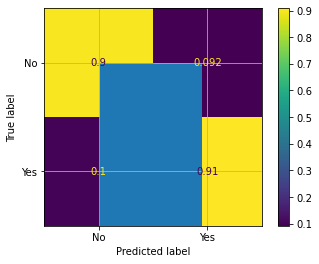

In [12]:
df_model, df_ml = ml_functions.model_preparation(df_ml,class_nsp)
X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, parameters = ml_functions.data_splitting(df_model)
model = ml_functions.model_training(X_train, y_train, numerical_cols, categorical_cols, parameters)
model = ml_functions.model_evaluation(model,X_test,y_test)
df = ml_functions.model_serving(df,model,class_nsp,X_test)
df['proba_classe_2.0'].hist()

## 3.3 Classe 3 - Anormale

In [13]:
class_nsp = 3.0

(352, 22)
AUC Score:  0.6235017123287672


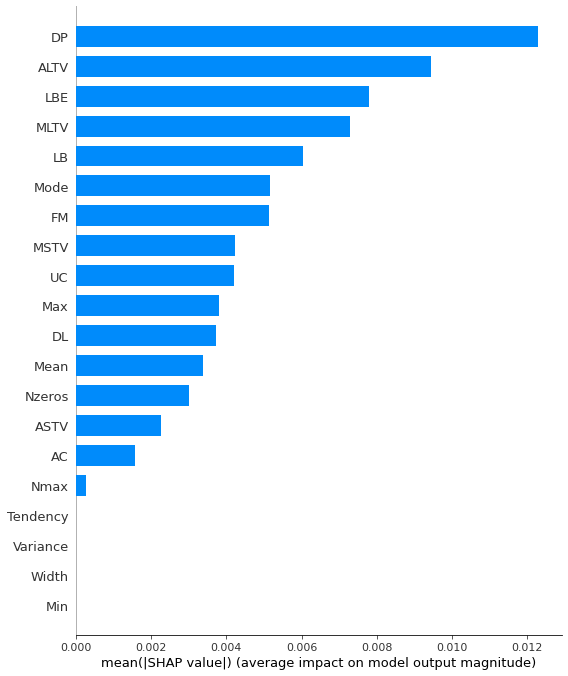

Adversarial validation check: YES CONCENPT DRIFT- Check features importance: Dev and Test set are not statistical similar
AUC Score:  0.5213600697471665
GridSearchCV results...
Mean Train Scores: 
[0.98577126 0.98475603 0.99491868 0.99695431]

Mean CV Scores: 
[0.95134694 0.95534694 0.95126531 0.95126531]

Best Parameters: 
{'model__depth': 2, 'model__iterations': 200}

Test results...
Model Test Accuracy: 0.9528301886792453
--------------------------------------------------
Model Test Confusion Matrix
First ten features by importances:
['Mean', 'ALTV', 'ASTV', 'DP', 'Mode', 'Variance', 'AC', 'Median', 'MSTV', 'MLTV']


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

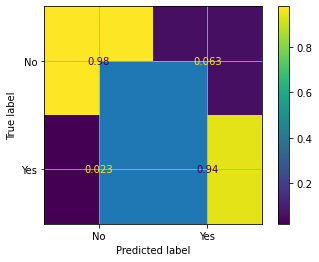

In [14]:
df_model, df_ml = ml_functions.model_preparation(df_ml,class_nsp)
X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, parameters = ml_functions.data_splitting(df_model)
model = ml_functions.model_training(X_train, y_train, numerical_cols, categorical_cols, parameters)
model = ml_functions.model_evaluation(model,X_test,y_test)
df = ml_functions.model_serving(df,model,class_nsp,X_test)
df['proba_classe_3.0'].hist()

# 4.0 Normalizing results

In [15]:
cols = ['proba_classe_1.0','proba_classe_2.0', 'proba_classe_3.0']

In [16]:
df[cols] = df[cols].apply(lambda x: x / x.sum(),axis=1)

# 5.0 Beta Inference

In [17]:
xax = np.linspace(0,1.0,100)

In [18]:
num_classe = dict()
tot = 0
for i in df['NSP'].unique():
    num = df[df['NSP']==i].shape[0]
    tot = tot + num
    num_classe[i] = dict()
    num_classe[i]['num'] = num

In [19]:
for i in num_classe:
    num_classe[i]['wei'] = num_classe[i]['num'] / tot
    num_classe[i]['k'] = num_classe[i]['num'] * num_classe[i]['wei']

In [20]:
df['proba_classe_1.0_beta'] = df['proba_classe_1.0'].apply(lambda x: beta.pdf(xax,(x * (num_classe['1.0']['k']-2)+1),((1-x) * (num_classe['1.0']['k']-2)+1)))
df['proba_classe_2.0_beta'] = df['proba_classe_2.0'].apply(lambda x: beta.pdf(xax,(x * (num_classe['2.0']['k']-2)+1),((1-x) * (num_classe['2.0']['k']-2)+1)))
df['proba_classe_3.0_beta'] = df['proba_classe_3.0'].apply(lambda x: beta.pdf(xax,(x * (num_classe['3.0']['k']-2)+1),((1-x) * (num_classe['3.0']['k']-2)+1)))

Visual check

In [21]:
index = random.randint(0,2126)

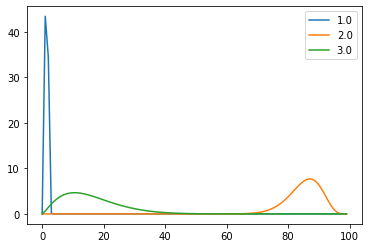

In [22]:
plt.plot(df['proba_classe_1.0_beta'][index],label='1.0')
plt.plot(df['proba_classe_2.0_beta'][index],label='2.0')
plt.plot(df['proba_classe_3.0_beta'][index],label='3.0')
plt.legend()

# 6.0 Output

In [23]:
df.sample(2)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP,proba_classe_1.0,proba_classe_2.0,proba_classe_3.0,proba_classe_1.0_beta,proba_classe_2.0_beta,proba_classe_3.0_beta
SegFile,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CTG0857.txt,142.0,142.0,0.0,0.0,2.0,43.0,0.8,3.0,9.6,0.0,0.0,0.0,25.0,132.0,157.0,1.0,0.0,145.0,144.0,146.0,1.0,0.0,1.0,0.706866,0.268296,0.024838,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.155721420410893e-11, 4.327492098592659...","[0.0, 7.0832272135096215, 7.755610272999106, 7..."
CTG1177.txt,126.0,126.0,0.0,0.0,2.0,28.0,1.3,0.0,10.8,0.0,0.0,0.0,34.0,107.0,141.0,1.0,0.0,127.0,128.0,128.0,3.0,0.0,1.0,0.867956,0.101483,0.030561,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.026934283579670086, 0.2909896970229449...","[0.0, 6.167046861293726, 7.102962587600739, 7...."
